In [1]:
#  Organize the data in a way suitable to use for statistics.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import nan

# ------ LOAD data-tables ---------------------------------------------------- 
# List of clinical table with features and timepoints
path_Klinisk  = "/Users/mattesa/molbreastlab-storage/work/Radiation_study/Matteo/ClinicalData_Klinisk.csv" 
path_Oversikt = "/Users/mattesa/molbreastlab-storage/work/Radiation_study/Matteo/ClinicalData_Oversikt.csv" 
path_Lipopro  = "/Users/mattesa/molbreastlab-storage/work/Radiation_study/Matteo/Lipoproteinene_Combined2.csv" 

root_path = os.path.dirname(path_Lipopro)
             
# Load clinical data file: it contains all the metadata on medications, 
# treatments, sample collection timepoints etc...
# Specifically, load the sheets "Oversikt" and "Klinik fra Randi"
CD_klinisk = pd.read_csv( path_Klinisk,  header=1, index_col=False)
CD_oversik = pd.read_csv( path_Oversikt, header=0, index_col=False)
   
# Load Lipoprotein measurments file: it contains all the measurments for all 
# the blood plasma lipoproteins (only). 
# NOTE: There are some redundant columns
LP_measure = pd.read_csv( path_Lipopro, header=0, index_col=False)


# ------ PRUNING the data ----------------------------------------------------
# Extract the timepoints as defined by Guro, but also the date itself, which 
# can be used to pairs entries in different tables.
#result = pd.merge(left, right, on="key")
sele_oversik  = [ "PatientID", 
                  "Samplenames lipo", "Names date modified", "Samling date", 
                  "Dato stråleterapi", "Timepoint", "Timepoint_kodet" ]
CD_timepoints = CD_oversik.loc[:,sele_oversik]

# Rename column "Samplenames lipo" in CD_oversik === "name" in LP_measure
CD_timepoints = CD_timepoints.rename(columns={"Samplenames lipo": "Samplename"})
LP_measure    = LP_measure.rename(columns={"name": "Samplename"})

# Insert a "PatientID" column in LP_measure dataframe as well (redundant but good practice)
LP_measure.insert( loc=1, column="PatientID", value=CD_timepoints["PatientID"])

# Find missing samples, samples (CD_oversik) that have no measurement (LP_measure)
# Do set-difference to find missing samples, then a second one to remove them 
# from the list, and in turn from the dataframe
miss_nn = np.setdiff1d( CD_timepoints["Samplename"], LP_measure["Samplename"])
list_nn = np.setdiff1d( CD_timepoints["Samplename"], miss_nn )
CD_timepoints = CD_timepoints.loc[CD_timepoints["Samplename"].isin(list_nn)]

# Remove quality control measurments: string value starting with "QC"
mask_QC = ["QC" not in xx   for xx in LP_measure["Samplename"]]
LP_measure    = LP_measure.loc[ mask_QC, : ]
CD_timepoints = CD_timepoints.loc[ mask_QC, : ]

# At this point we should have the exact same entries in both DataFrames. 
# We can sort-by name columns "Samplename" and "name" should be
# equivalent in both tables
CD_timepoints = CD_timepoints.sort_values("Samplename")
LP_measure    = LP_measure.sort_values("Samplename")

# Some timepoints are uncategorized, and must be removed
mask = CD_timepoints["Timepoint_kodet"].isnull().values
LP_measure    = LP_measure.loc[ ~mask, : ]
CD_timepoints = CD_timepoints.loc[ ~mask, : ]

# Now that we have same order and have sorted tables, we can reindex both.
# Thus, both are sorted and have same row index
LP_measure = LP_measure.reset_index(drop=True)
CD_timepoints = CD_timepoints.reset_index(drop=True)

# ------ SAVE ----------------------------------------------------------------
# Save as Python-Ready .csv file
LP_measure.to_csv(    root_path + "/PyR_Lipoproteine.csv", header=True, index=True)
CD_timepoints.to_csv( root_path + "/PyR_Timepoints.csv"  , header=True, index=True)

In [293]:
import sys
# Add as desired to the list of known working paths for Python 
sys.path.append('F:/Python/')

import mbc_PLS_basic
from mbc_PLS_basic import *
# Force reload during development, otherwise Python only loads first time 
# and does not update unless the kernel is rebooted
import importlib
importlib.reload(mbc_PLS_basic)

#import sklearn
#from sklearn.preprocessing       import StandardScaler
#from sklearn.cross_decomposition import PLSRegression
#from sklearn.model_selection     import cross_val_predict


# --- 0 --- Parameters for the cross validation ------------------------------
max_N_comp = 10           # Maximum number of components to tes
outer_PropSele = 0.2      # proportion train-to-test to use
inner_PropSele = 0.2    
outer_loop  = 6           # cycles number to perform double cross val.
inner_loop  = 3
p_threshold = 3           # predicted probability threshold
min_cat  = 1
max_cat = 5

# Column name for the response variable to use in PLS-DA
unique_PatientID_Col = "PatientID"
Response_Col         = "Timepoint_kodet"


# --- 1 --- Prepare the DataFrames in the appropriate format -----------------
# Prepare the data we wish to use for the PLS model in XX and YY dataframes.
# Scale-standardize the XX matrix and reduce selection only for data with 
# specific values in "Response_Col" column (min_cat, max_cat)
YY = CD_timepoints.copy()
XX_vars_scaled, XX_scaled = StandardScale_FeatureTable( LP_measure , 4)
XX, YY = CrossSelect_TwoTables( XX_vars_scaled, YY, Response_Col, [min_cat,max_cat] ) 


# --- 2 --- Cross-validation of PLS ------------------------------------------
accuracy, comparPred = optimise_PLS_CrossVal(
                          XX, YY, max_N_comp, unique_PatientID_Col,
                          Response_Col, min_cat, max_cat, p_threshold , 
                          outer_loop, inner_loop, outer_PropSele, inner_PropSele)

comparPred.head(20)
accuracy



,o1,o2,o3,o4,o5,o6
Suggested_N_comp,9.00,4.000000,7.000000,6.000000,9.000000,3.000000
Accuracy,0.88,0.813333,0.810811,0.805195,0.794521,0.810811


(-15, 15)

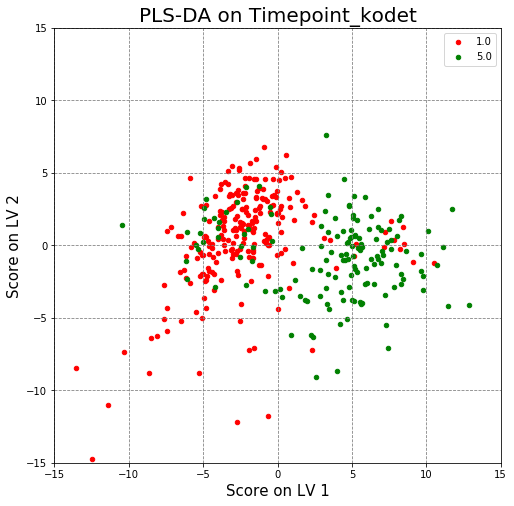

In [294]:

# --- 3 --- Plot PLS by Response_Col --------------------------------------------

PLS_scores = PLS_fit_model( XX, YY.loc[:, Response_Col ], 3, Response_Col)

# We create a 2D scatter plot, we only need to take the first two latent 
# variables and the response column (the last). We color each category 
# (targets) with a unique color
plotDF = PLS_scores.iloc[:,[0,1,-1]]

targets = np.sort( plotDF[Response_Col].unique() )
colors  = ['r', 'g', 'b', 'k', 'm', 'c', 'o']

fig = plt.figure(figsize = (8,8))
ax  = fig.add_subplot(1,1,1) 

# Plot the PCA in as 2D scatterplot and uniquely  color each flowcell data
for target, color in zip(targets,colors):
    ind_xx = plotDF[Response_Col] == target
    ax.scatter( plotDF.loc[ind_xx, 'Score_LV_1'], 
                plotDF.loc[ind_xx, 'Score_LV_2'], 
                c = color,
                s = 20)
ax.set_xlabel('Score on LV 1', fontsize = 15)
ax.set_ylabel('Score on LV 2', fontsize = 15)
ax.set_title('PLS-DA on '+ Response_Col , fontsize = 20)
ax.legend(targets)
plt.grid(color = "grey", linestyle='--')
nn = 15
ax.set_xlim([-nn, nn])
ax.set_ylim([-nn, nn])

# --- SAVE the plot ----------------------------------------------------------
# plt.savefig("PLS-DA_Timepoint_"+region+".svg")

In [144]:
innerMSE

,lv1,lv2,lv3,lv4,lv5,lv6,lv7,lv8,lv9,lv10,lv11,lv12,lv13,lv14,lv15,lv16,lv17,lv18,lv19,lv20
i1,2.168892,2.038056,1.897941,1.993413,1.997811,1.979025,2.254908,2.202110,2.280438,2.369870,2.349112,2.316186,2.293044,2.184996,2.125124,2.108810,2.237035,2.426691,2.287719,2.348508
i2,2.297023,2.237248,2.304814,2.437346,2.394342,2.300359,2.314936,2.276475,2.257996,2.245367,2.255812,2.266699,2.274538,2.215586,2.331833,2.420454,2.375936,2.442907,2.384413,2.456750
i3,3.199045,3.094268,3.093928,3.068141,3.083239,2.949278,2.802708,2.827490,2.939868,2.919445,2.838085,2.843982,2.859349,2.868276,3.016419,2.961155,3.007926,3.030688,3.052694,3.052848


In [289]:
outerMSE

,lv1,lv2,lv3,lv4,lv5,lv6,lv7,lv8,lv9,lv10
o1,2.253611,2.137724,2.131652,2.144554,2.051769,1.939448,2.044570,1.960789,1.967209,2.008326
o2,2.024844,1.951056,1.933805,1.970503,1.958872,1.962882,2.001039,1.980820,1.944342,1.927154
o3,2.426493,2.320246,2.373791,2.351203,2.414218,2.484418,2.461694,2.414662,2.433805,2.439224
o4,2.124655,2.025984,2.010825,2.012277,2.018440,2.041187,2.073125,2.119635,2.136968,2.107233


In [290]:

comparPred.head(20)

,oY_test,oY_pred,Y_pred_thres,T-F
0,5,1.36136,1,False
1,5,1.05205,1,False
2,1,1.85523,1,True
3,1,1.99354,1,True
4,5,1.58915,1,False
5,5,1.70286,1,False
6,5,1.81874,1,False
7,1,1.44564,1,True
8,1,1.11396,1,True
9,5,1.15406,1,False
